In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for visualizations
plt.style.use('seaborn')
sns.set_palette("husl")

In [3]:
# Load data
train_data = pd.read_csv('/kaggle/input/innovative-ai-challenge-2024/train.csv')
test_data = pd.read_csv('/kaggle/input/innovative-ai-challenge-2024/test.csv')

In [4]:
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (55, 8)
Test data shape: (8, 7)


In [5]:
# Data preprocessing function
def preprocess_data(train_data, test_data):
    """
    Preprocess training and test data.
    """
    # Create copies to avoid modifying original data
    train = train_data.copy()
    test = test_data.copy()
    
    # Drop ID column
    if 'id' in train.columns:
        train = train.drop('id', axis=1)
    
    # Encode categorical variables
    categorical_cols = ['State', 'Crop_Type', 'Soil_Type']
    encoders = {}
    
    for feature in categorical_cols:
        encoders[feature] = LabelEncoder()
        train[feature] = encoders[feature].fit_transform(train[feature])
        test[feature] = encoders[feature].fit_transform(test[feature])
    
    # Scale numerical features
    scaler = StandardScaler()
    numerical_cols = ['Rainfall', 'Irrigation_Area']
    
    train[numerical_cols] = scaler.fit_transform(train[numerical_cols])
    test[numerical_cols] = scaler.transform(test[numerical_cols])
    
    return train, test, encoders

In [6]:
# Feature importance visualization function
def plot_feature_importance(model, feature_names):
    """
    Plot feature importance from the trained model.
    """
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importances)
    plt.title('Feature Importance in Crop Yield Prediction', pad=20)
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    
    return importances

In [7]:
# EDA visualizations
def plot_eda(data):
    """
    Create exploratory data analysis plots.
    """
    # Crop yield distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(data=data, x='Crop_Yield (kg/ha)', bins=30)
    plt.title('Distribution of Crop Yield')
    plt.show()
    
    # Yield by crop type
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='Crop_Type', y='Crop_Yield (kg/ha)')
    plt.title('Crop Yield by Crop Type')
    plt.show()
    
    # Correlation between numerical features
    plt.figure(figsize=(10, 6))
    numerical_cols = ['Year', 'Rainfall', 'Irrigation_Area', 'Crop_Yield (kg/ha)']
    sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

In [8]:
# Model training and evaluation
def train_model(X_train, y_train, X_test, y_test):
    """
    Train and evaluate the Random Forest model.
    """
    # Define parameter grid for RandomizedSearchCV
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    # Initialize and train model
    rf = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=30,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    # Get best model
    best_model = random_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\nModel Performance:")
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {np.sqrt(mse):.2f}")
    print(f"R2 Score: {r2:.4f}")
    
    return best_model


Performing Exploratory Data Analysis...


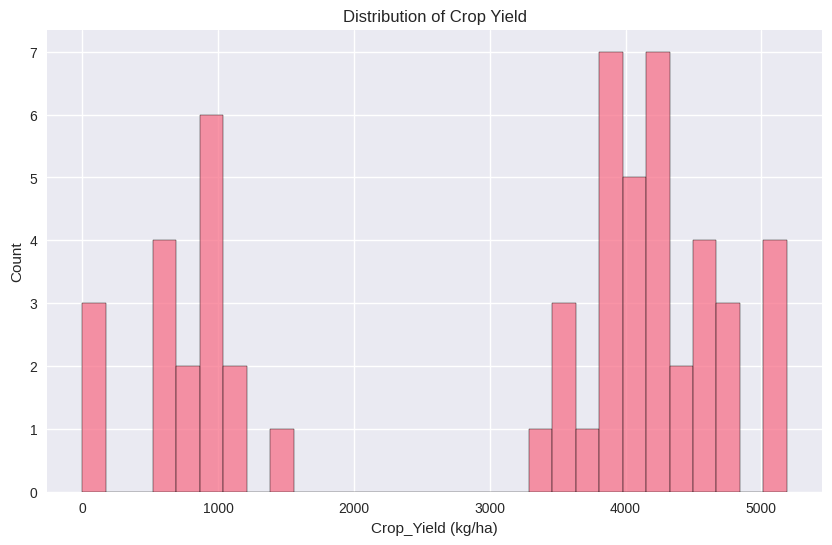

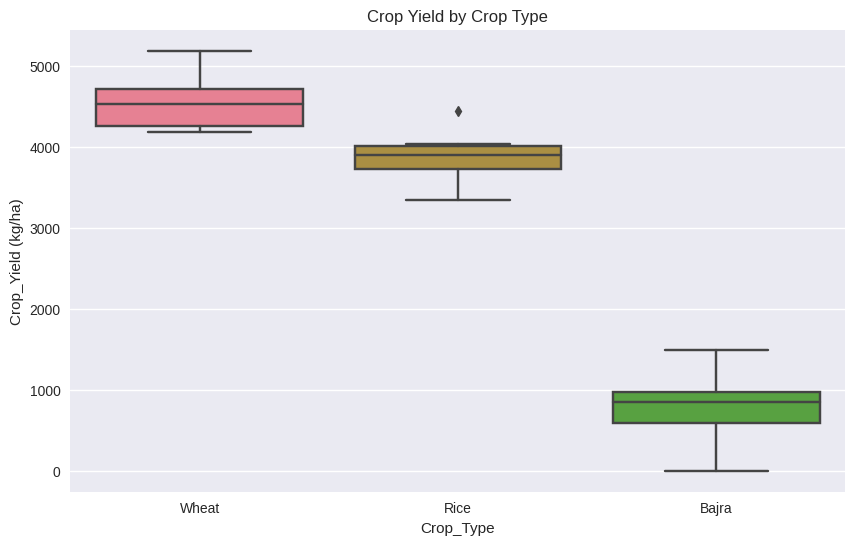

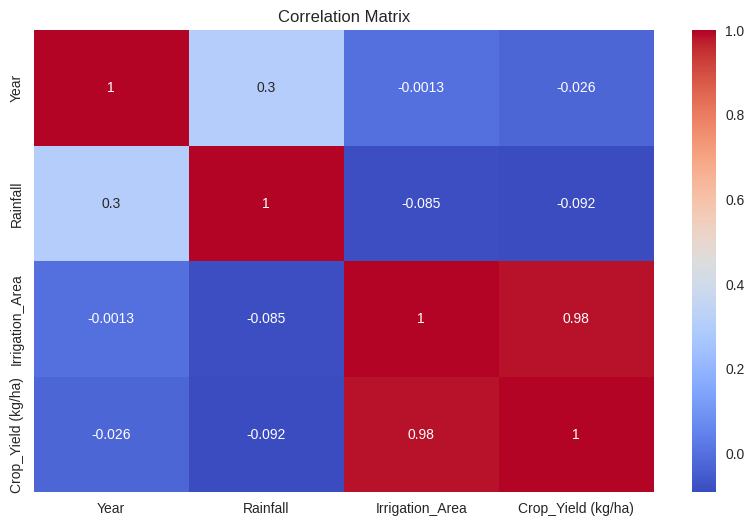


Training model...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Model Performance:
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40}
MSE: 97762.85
RMSE: 312.67
R2 Score: 0.9689

Plotting feature importance...


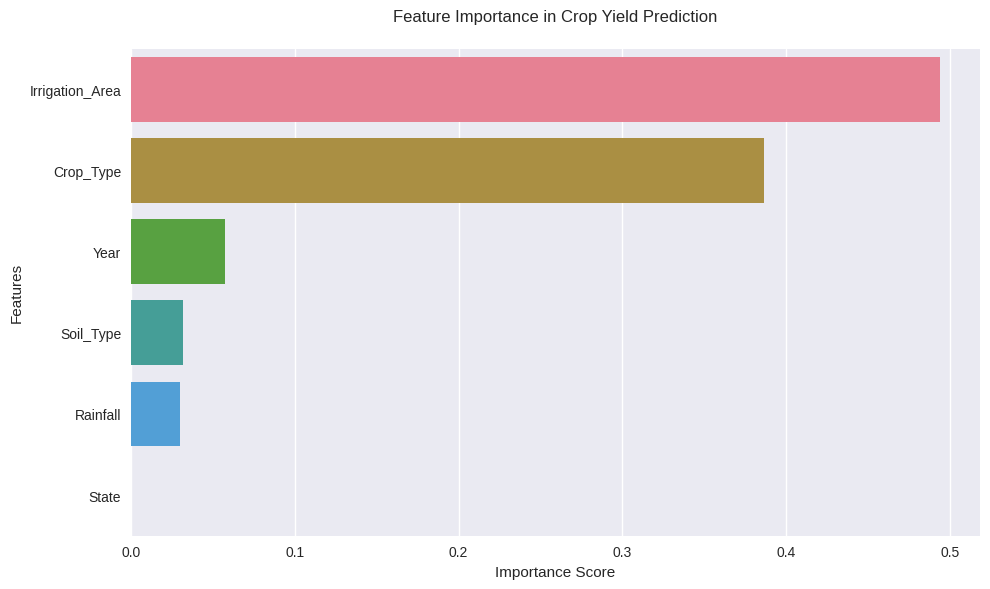


Generating predictions for test data...

Submission file created successfully!
Shape of submission file: (8, 2)

First few predictions:
     id  Crop_Yield (kg/ha)
0  1001            4345.955
1  1002            4651.080
2  1003            4084.175
3  1004            4069.715
4  1005            4026.020


In [9]:
# Main execution
if __name__ == "__main__":
    # Preprocess data
    train_processed, test_processed, encoders = preprocess_data(train_data, test_data)
    
    # Perform EDA
    print("\nPerforming Exploratory Data Analysis...")
    plot_eda(train_data)
    
    # Prepare features and target
    X = train_processed.drop('Crop_Yield (kg/ha)', axis=1)
    y = train_processed['Crop_Yield (kg/ha)']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train model
    print("\nTraining model...")
    model = train_model(X_train, y_train, X_test, y_test)
    
    # Plot feature importance
    print("\nPlotting feature importance...")
    feature_importance = plot_feature_importance(model, X.columns)
    
    # Generate predictions for test data
    print("\nGenerating predictions for test data...")
    test_features = test_processed.drop('id', axis=1)
    test_predictions = model.predict(test_features)
    
    # Create submission file
    submission = pd.DataFrame({
        'id': test_data['id'],
        'Crop_Yield (kg/ha)': test_predictions
    })
    
    submission.to_csv('/kaggle/working/submission.csv', index=False)
    print("\nSubmission file created successfully!")
    print("Shape of submission file:", submission.shape)
    print("\nFirst few predictions:")
    print(submission.head())